# Projeto_2

## Import of python libraries

In this section there are all the libraries used in the entire file listed so that it may be easy to read

In [34]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import sqrt
from geopy.geocoders import Nominatim
import datetime
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
import holidays
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Functions used along the code

All the function used along the code are listed here

In [2]:
def get_city_population(city):
    url = 'https://en.wikipedia.org/wiki/List_of_largest_cities_and_towns_in_Turkey'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', class_='wikitable')
    rows = table.find_all('tr')[1:]  # Exclude the header row
    for row in rows:
        columns = row.find_all('td')
        if columns[1].text.strip() == city:
            population = columns[6].text.strip()
            return population
    return 'Population not found'

def latitude(city):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.geocode(city)
    if location is not None:
        latitude = location.latitude
        return latitude
    else:
        return "Latitude not found"
    
def longitude(city):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.geocode(city)
    if location is not None:
        longitude = location.longitude
        return longitude
    else:
        return "Longitude not found"
    
def season(date):
    month = date.strftime('%B')
    day = date.day
    if month in ('January', 'February', 'March'):
        season = 'winter'
    elif month in ('April', 'May', 'June'):
        season = 'spring'
    elif month in ('July', 'August', 'September'):
        season = 'summer'
    else:
        season = 'autumn'
    if (month == 'March') and (day > 20):
        season = 'spring'
    elif (month == 'June') and (day > 20):
        season = 'summer'
    elif (month == 'September') and (day > 22):
        season = 'autumn'
    elif (month == 'December') and (day > 21):
        season = 'winter'
    return season

"""
def holidays(date):
    year = date.strftime('%Y')
    formated = date.strftime('%#d %B')
    url = 'https://en.wikipedia.org/wiki/Public_holidays_in_Turkey'
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the table containing the holiday data
    table = soup.find_all('table', 'wikitable')[0]
    rows = table.find_all('tr')[1:]
    for row in rows:
        # Extract the cells of each row
        columns = row.find_all('td')
        if columns[0].text.strip() == formated:
            name = columns[1].text.strip()
            return name
    return 'Not Holiday'
"""

"\ndef holidays(date):\n    year = date.strftime('%Y')\n    formated = date.strftime('%#d %B')\n    url = 'https://en.wikipedia.org/wiki/Public_holidays_in_Turkey'\n    response = requests.get(url)\n    html_content = response.content\n    soup = BeautifulSoup(html_content, 'html.parser')\n\n    # Find the table containing the holiday data\n    table = soup.find_all('table', 'wikitable')[0]\n    rows = table.find_all('tr')[1:]\n    for row in rows:\n        # Extract the cells of each row\n        columns = row.find_all('td')\n        if columns[0].text.strip() == formated:\n            name = columns[1].text.strip()\n            return name\n    return 'Not Holiday'\n"

## Data cleaning

In this section some data cleaning will be performed. The city names were corrected, null values were replaced using the interpolate function of pandas, aswell as a k-nearest neighbors algorithm, for the first 2 csv files.  
For the third csv file, some columns were droped, and null values were filed, around 7000 null values remain which means that ir represents less than 1 % of the entire csv file, so we made the decision to drop those lines.

In [38]:
product_df = pd.read_csv("product.csv")
product_df.shape
product_df.info()
print(product_df.duplicated().any())
# Check for nulls and replace missing values
print(product_df.isna().sum())
product_df["product_length"].interpolate(method ='linear', limit_direction ='both', inplace=True)
product_df["product_depth"].interpolate(method ='linear', limit_direction ='both', inplace=True)
product_df["product_width"].interpolate(method ='linear', limit_direction ='both', inplace=True)
print(product_df.isna().sum())

# Split the data into complete and missing
complete_data = product_df.dropna()
missing_data = product_df[product_df['cluster_id'].isnull()].drop('cluster_id', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    complete_data[['product_length', 'product_depth', 'product_width']],
    complete_data['cluster_id'],
    test_size=0.2,
    random_state=42
)

# Perform K-nearest neighbors classification with hyperparameter tuning
parameters = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Best hyperparameters and model
best_k = grid_search.best_params_['n_neighbors']
best_weights = grid_search.best_params_['weights']
best_algorithm = grid_search.best_params_['algorithm']
best_leaf_size = grid_search.best_params_['leaf_size']
best_p = grid_search.best_params_['p']
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Predict clusters for missing data using the best model
missing_data['cluster_id'] = best_model.predict(missing_data[['product_length', 'product_depth', 'product_width']])

# Concatenate the complete data with the imputed missing data
result_df = pd.concat([complete_data, missing_data])

# Print the resulting DataFrame with clusters
print(result_df)
print(result_df.isna().sum())

result_df.to_csv("product_df.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      699 non-null    object 
 1   product_length  681 non-null    float64
 2   product_depth   683 non-null    float64
 3   product_width   683 non-null    float64
 4   cluster_id      649 non-null    object 
 5   hierarchy1_id   699 non-null    object 
 6   hierarchy2_id   699 non-null    object 
 7   hierarchy3_id   699 non-null    object 
 8   hierarchy4_id   699 non-null    object 
 9   hierarchy5_id   699 non-null    object 
dtypes: float64(3), object(7)
memory usage: 54.7+ KB
False
product_id         0
product_length    18
product_depth     16
product_width     16
cluster_id        50
hierarchy1_id      0
hierarchy2_id      0
hierarchy3_id      0
hierarchy4_id      0
hierarchy5_id      0
dtype: int64
product_id         0
product_length     0
product_depth      0
product_wi

In [4]:
sales_df = pd.read_csv("sales.csv")
sales_df = sales_df[sales_df["date"] < "2019-09-30"]
# We chose data before 30 of september because it is a monday and the first week of october

sales_df = sales_df.drop(sales_df.columns[0], axis=1)
print(sales_df.isna().sum())
print(len(sales_df))

#fill the price
sales_df['price'] = sales_df.groupby('product_id')['price'].transform(lambda x: x.fillna(x.mean()))
print(sales_df.isna().sum())
#after this some nulls still remain, that means that the dataset contains products for which there isnt a price in any place

#drop columns with a lot of nulls
sales_df.drop(['promo_bin_2', 'promo_discount_2', 'promo_discount_type_2'], axis=1, inplace=True)

#count distinct values of a column
value_counts = sales_df['promo_type_2'].value_counts()
print(value_counts)

# Given that less than one percent of the data related to promo_type_2 is different from the majority of the values
# we will drop this column aswell
sales_df.drop(['promo_type_2'], axis=1, inplace=True)

value_counts = sales_df['promo_type_1'].value_counts()
print(value_counts)

value_counts = sales_df['promo_bin_1'].value_counts()
print(value_counts)

sales_df['promo_bin_1'].fillna("none", inplace=True)

#binary_cols = pd.get_dummies(sales_df['promo_bin_1'], prefix='promo_bin_')
#sales_df = pd.concat([sales_df, binary_cols], axis=1)

#binary_cols = pd.get_dummies(sales_df['promo_type_1'], prefix='promo_type_')
#sales_df = pd.concat([sales_df, binary_cols], axis=1)

#sales_df.drop(['promo_type_1', 'promo_bin_1'], axis=1, inplace=True)

# Assignin a value to the remaing null values of the price to 0 because we dont want to lose the rest of the information
# its around 7000 so less then 1% see after model if it affects a lot, and wew dont want to lose entire values because of the price

#sales_df.dropna(inplace=True)
sales_df['price'].fillna("0", inplace=True)
print(sales_df.isna().sum())

sales_df.head()
print(len(sales_df))
sales_df.to_csv("sales_df.csv", index=False)

store_id                       0
product_id                     0
date                           0
sales                          0
revenue                        0
stock                          0
price                      89354
promo_type_1                   0
promo_bin_1              7393924
promo_type_2                   0
promo_bin_2              8565802
promo_discount_2         8565802
promo_discount_type_2    8565802
dtype: int64
8574076
store_id                       0
product_id                     0
date                           0
sales                          0
revenue                        0
stock                          0
price                       6617
promo_type_1                   0
promo_bin_1              7393924
promo_type_2                   0
promo_bin_2              8565802
promo_discount_2         8565802
promo_discount_type_2    8565802
dtype: int64
PR03    8565802
PR02       6088
PR01       2098
PR04         88
Name: promo_type_2, dtype: int64
PR14    739

### Adding external variables 

In [5]:
cities_df = pd.read_csv("cities.csv")
cities_df['city_code'] = cities_df['city_code'].str.replace('?', 'i')
cities_df['city_code'] = cities_df['city_code'].str.replace('Sanliurfa', 'Şanlıurfa')
cities_df['city_code'] = cities_df['city_code'].str.replace('Izmir', 'İzmir')
cities_df['city_code'] = cities_df['city_code'].str.replace('Diyarbakir', 'Diyarbakır')
cities_df['city_code'] = cities_df['city_code'].str.replace('Eskiiehir', 'Eskişehir')
cities_df['city_code'] = cities_df['city_code'].str.replace('Adapazari', 'Adapazarı')
cities_df['city_code'] = cities_df['city_code'].str.replace('Kahramanmaras', 'Kahramanmaraş')
cities_df['city_code'] = cities_df['city_code'].str.title()

In [6]:
# Add a new column to store population
cities_df['Population'] = cities_df['city_code'].apply(get_city_population)
cities_df['Latitude'] = cities_df['city_code'].apply(latitude)
cities_df['Longitude'] = cities_df['city_code'].apply(longitude)

print(cities_df)

#It doesnt work for Izmir so replace manually
cities_df['Population'] = cities_df['Population'].str.replace('Population not found', '2,847,691')

# remove the commas
cities_df['Population'] = cities_df['Population'].str.replace(',', '')

cities_df.to_csv("cities_df.csv", index=False)

   store_id storetype_id  store_size city_id_old country_id      city_code  \
0     S0036         ST04          21        C001     TURKEY        Denizli   
1     S0005         ST04          19        C001     TURKEY        Denizli   
2     S0104         ST04          47        C002     TURKEY         Ankara   
3     S0068         ST03          14        C003     TURKEY          Izmir   
4     S0086         ST03          12        C003     TURKEY          Izmir   
..      ...          ...         ...         ...        ...            ...   
58    S0040         ST04          42        C017     TURKEY  Kahramanmaraş   
59    S0046         ST04          26        C017     TURKEY  Kahramanmaraş   
60    S0102         ST04          27        C018     TURKEY        Erzurum   
61    S0032         ST03          14        C019     TURKEY            Van   
62    S0061         ST04          35        C019     TURKEY            Van   

              Population   Latitude  Longitude  
0             

In [11]:
# Define the start and end dates
start_date = date(2017, 1, 1)
end_date = date(2019, 11, 9)

# The reason to have the end_date as 9 of November is because the last week of October ends in 2 of November however one of our
# Exogenous variables is a binary column to know if there is holidays in the next week wich is why we have included the week after

# Create a list of dates
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# Create a DataFrame
df_1 = pd.DataFrame(date_list, columns=['Date'])
df_1['season'] = df_1['Date'].apply(season)

# Get the list of holidays for Turkey
holiday_list = []
for single_date in (start_date + timedelta(n) for n in range((end_date - start_date).days + 1)):
    holidays_data = holidays.Turkey(years=single_date.year).get(single_date)
    if holidays_data is not None:
        holiday_list.append((single_date, holidays_data))

# Create a DataFrame from the list of holidays
df = pd.DataFrame(holiday_list, columns=['Date', 'Holiday'])

# Print the DataFrame
print(df)

merged_df = pd.merge(df_1, df, on='Date', how='left')
print(merged_df)

#change some values manually
merged_df.to_csv("season_holidays.csv", index=False)

          Date                                         Holiday
0   2017-01-01                                  New Year's Day
1   2017-04-23         National Sovereignty and Children's Day
2   2017-05-01                                      Labour Day
3   2017-05-19  Commemoration of Ataturk, Youth and Sports Day
4   2017-06-25                     Ramadan Feast* (*estimated)
5   2017-06-26             Ramadan Feast Holiday* (*estimated)
6   2017-06-27             Ramadan Feast Holiday* (*estimated)
7   2017-07-15                Democracy and National Unity Day
8   2017-08-30                                     Victory Day
9   2017-09-01                   Sacrifice Feast* (*estimated)
10  2017-09-02           Sacrifice Feast Holiday* (*estimated)
11  2017-09-03           Sacrifice Feast Holiday* (*estimated)
12  2017-09-04           Sacrifice Feast Holiday* (*estimated)
13  2017-10-29                                    Republic Day
14  2018-01-01                                  New Yea

# Graphs

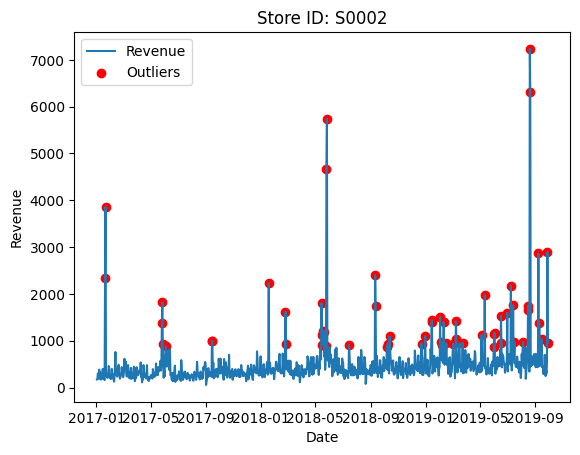

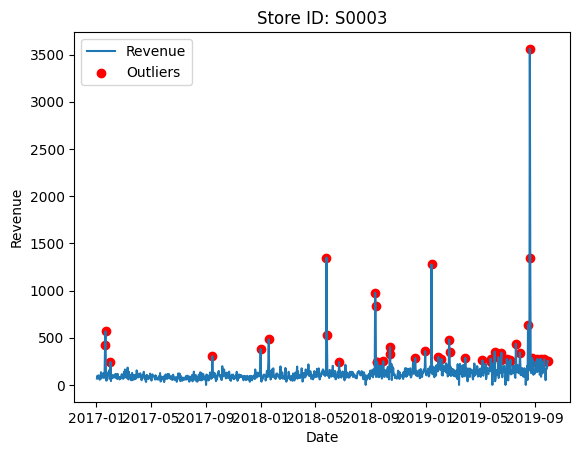

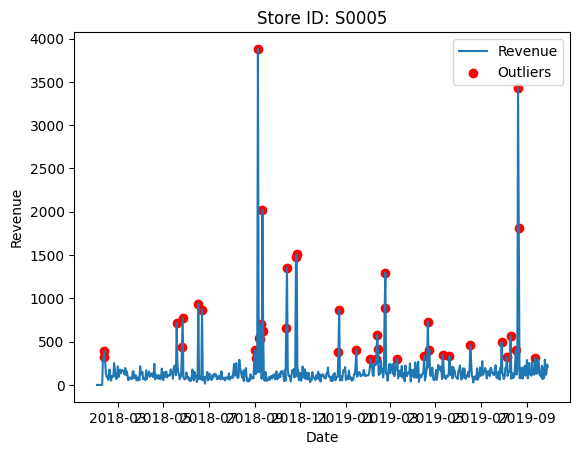

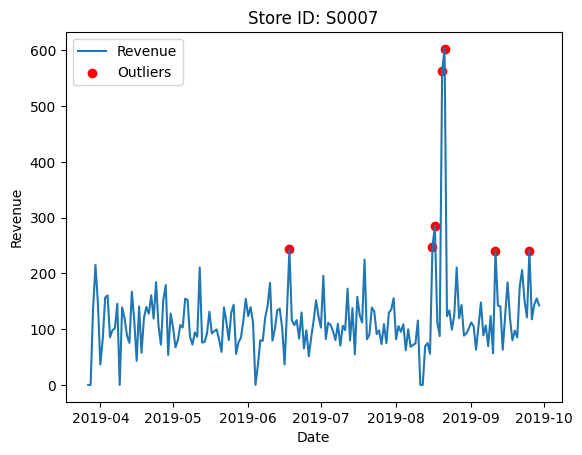

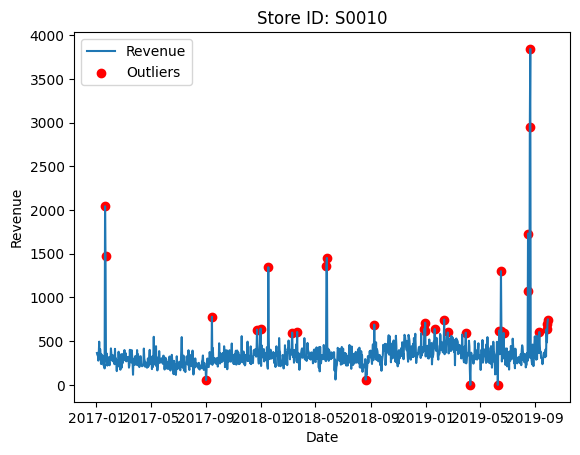

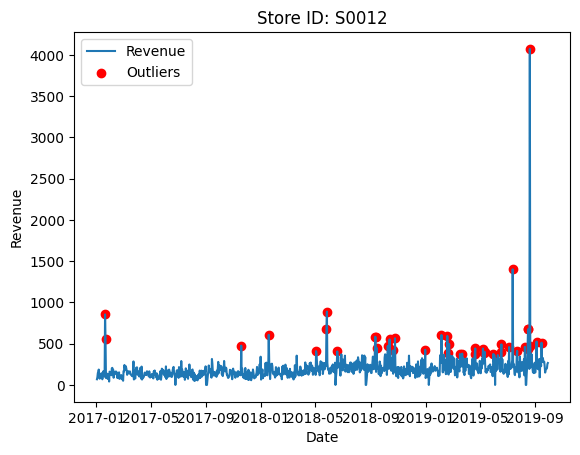

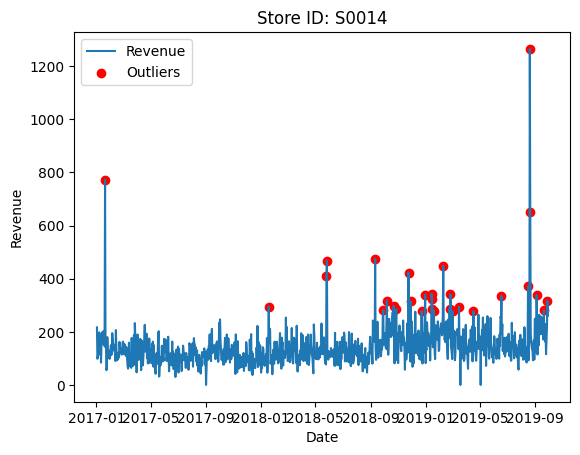

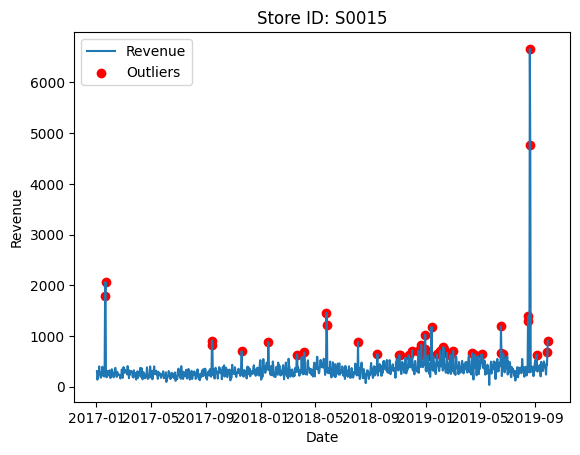

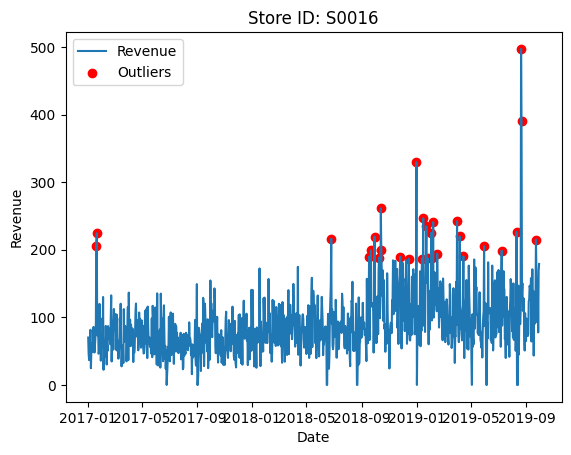

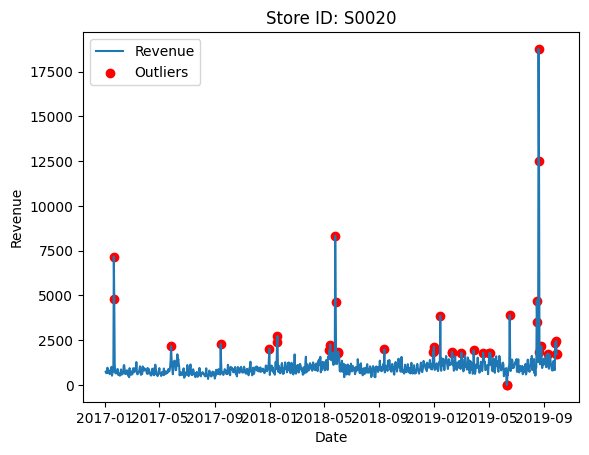

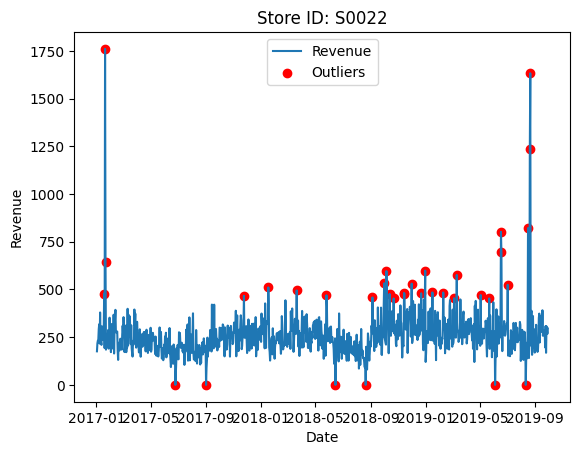

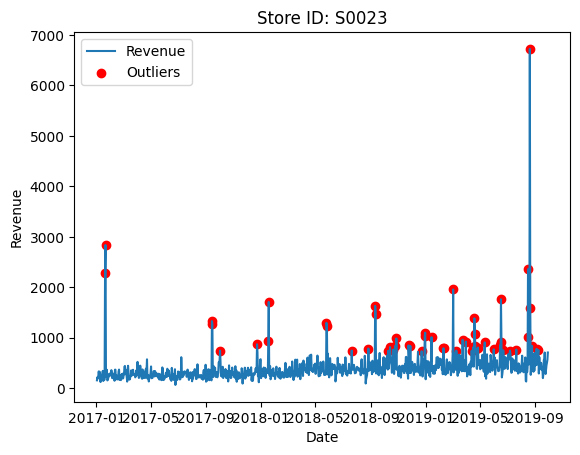

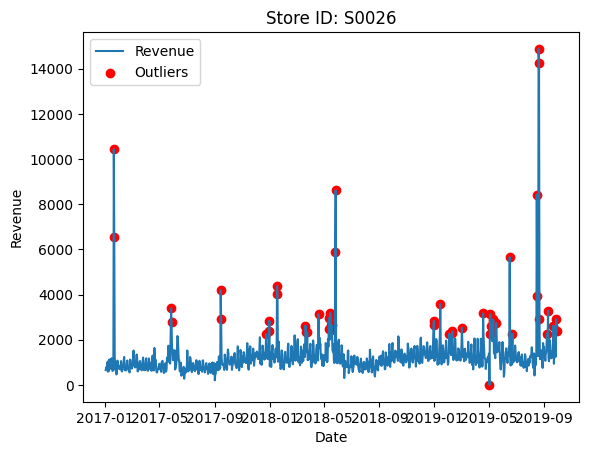

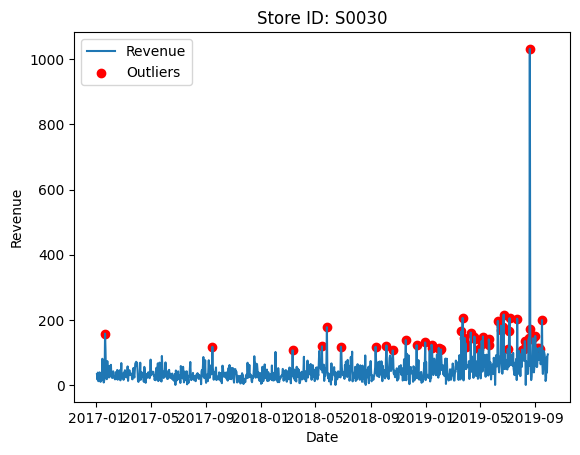

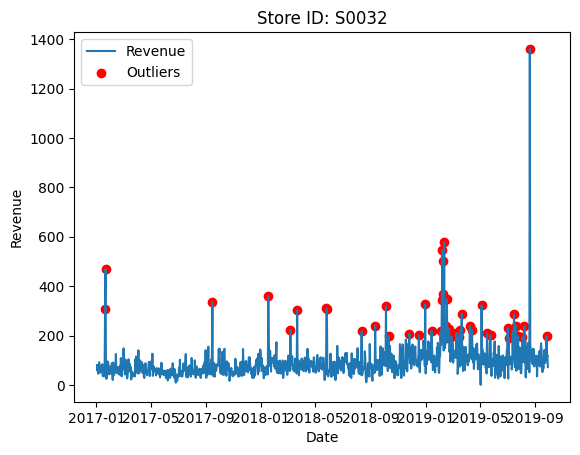

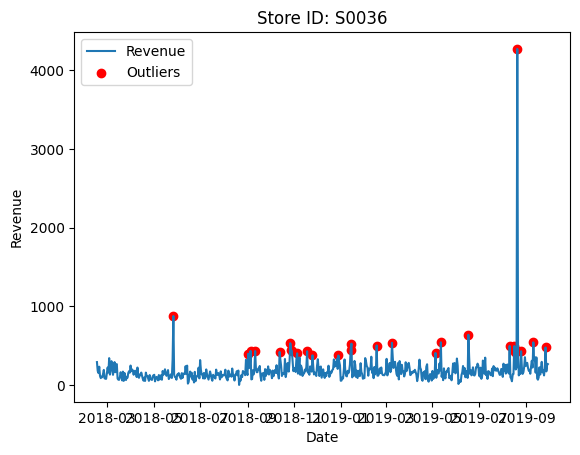

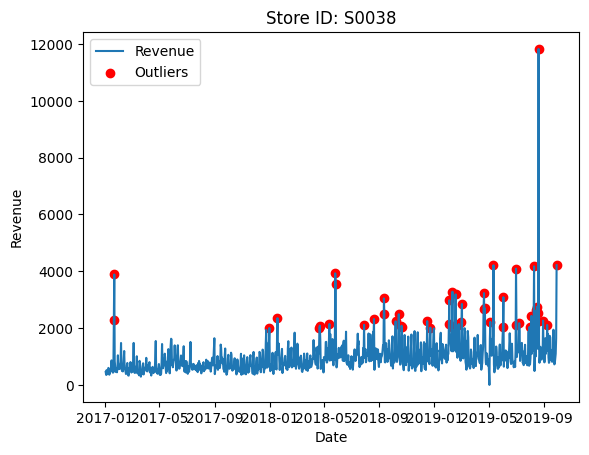

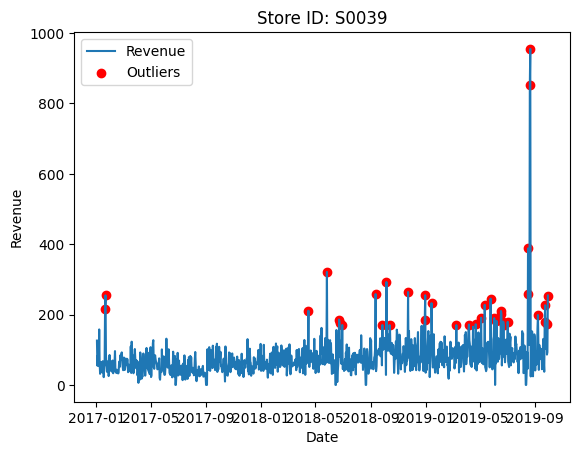

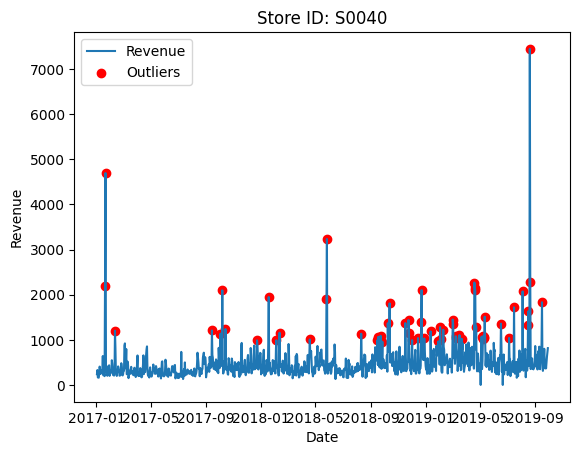

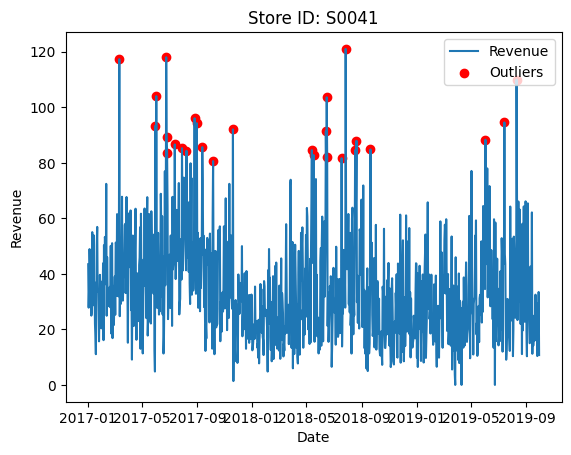

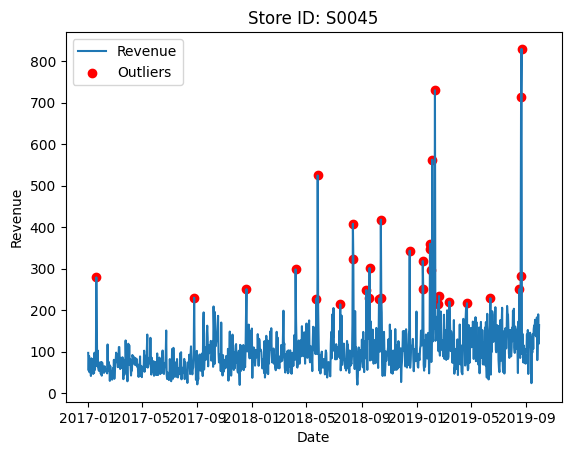

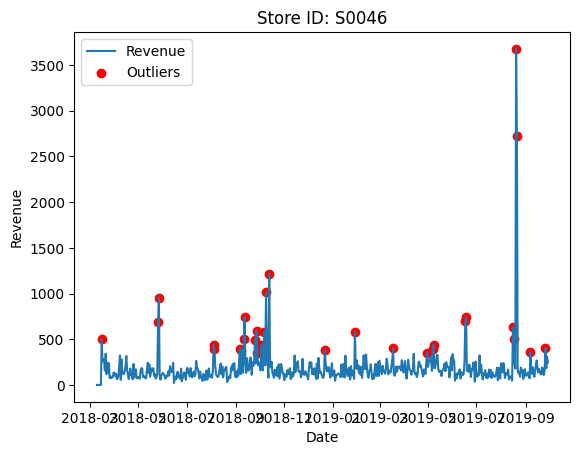

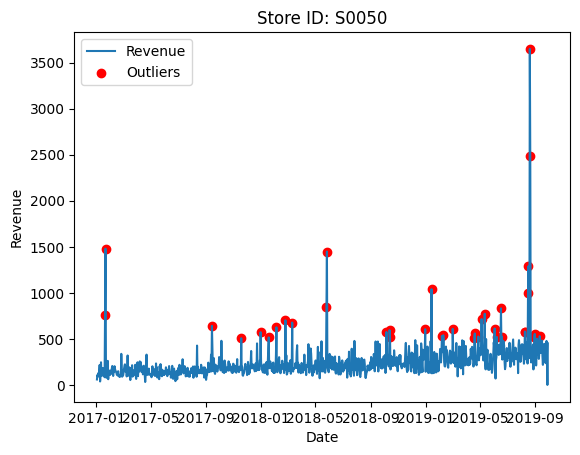

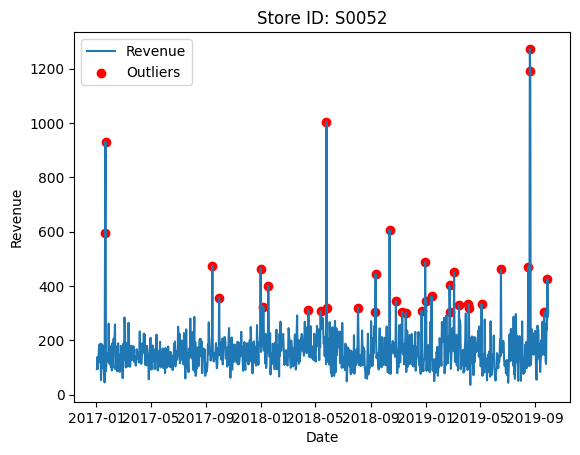

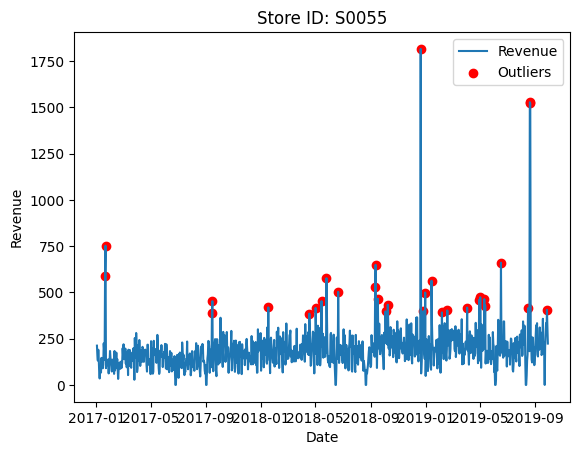

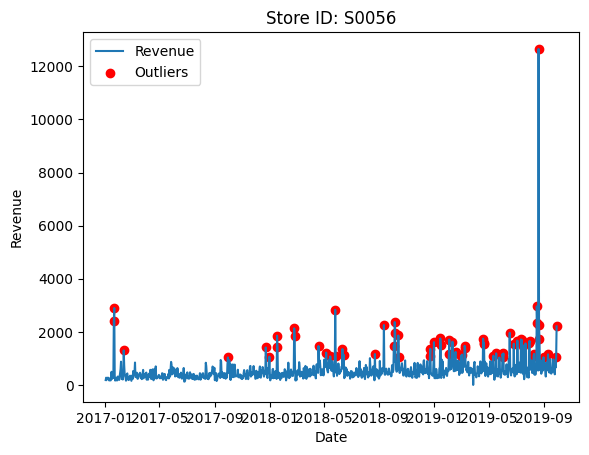

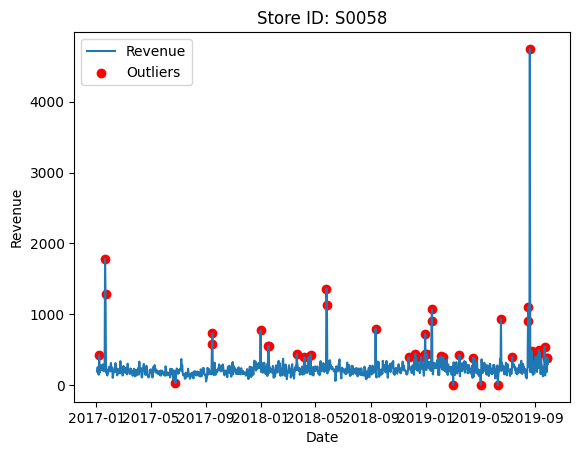

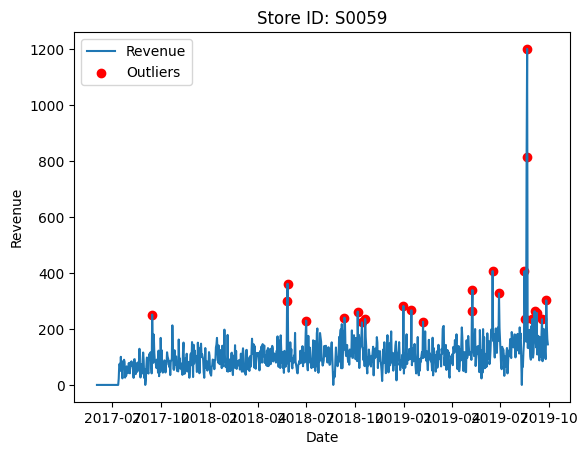

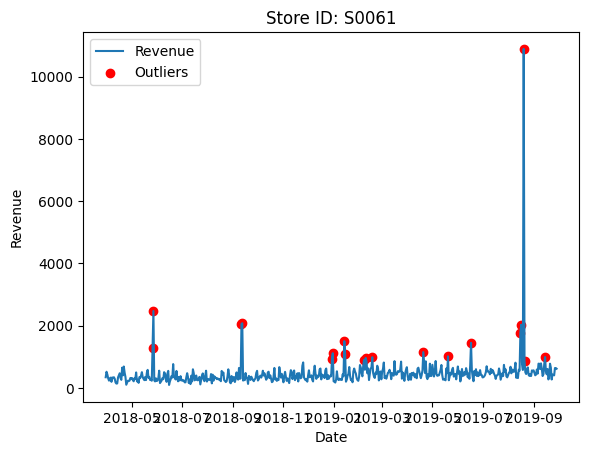

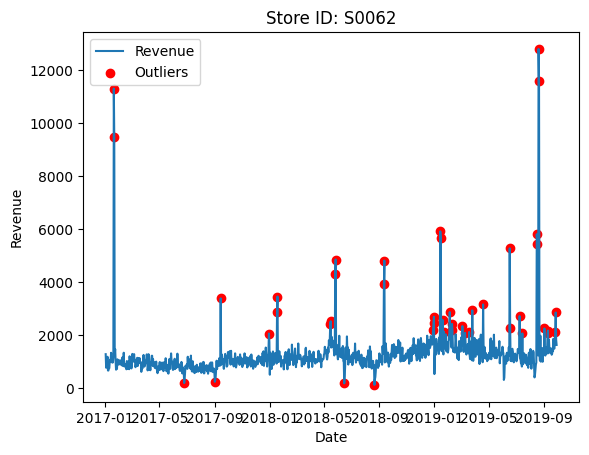

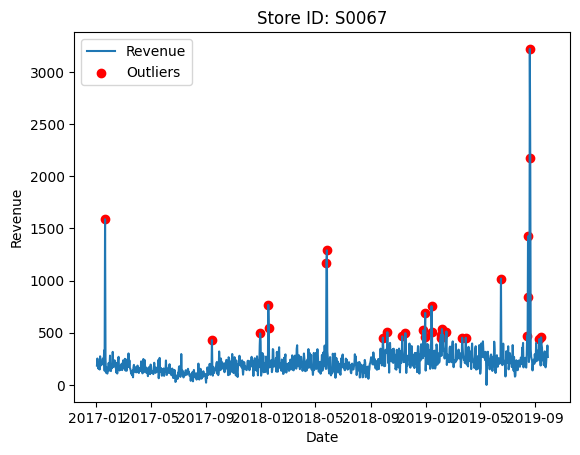

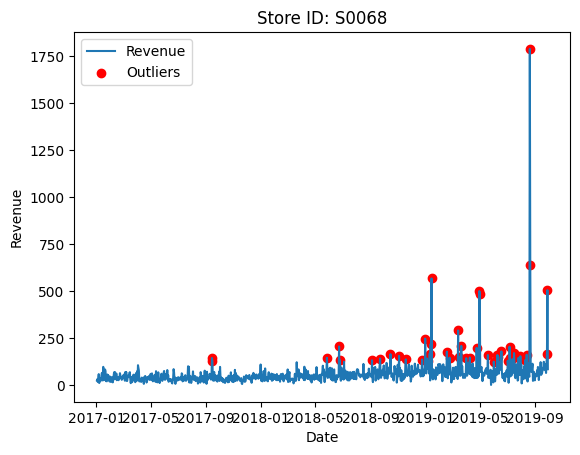

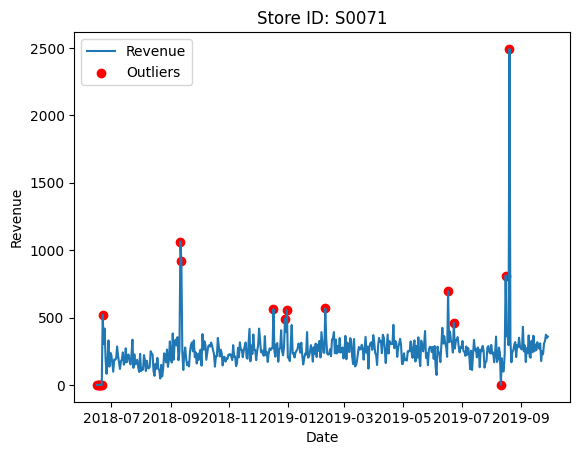

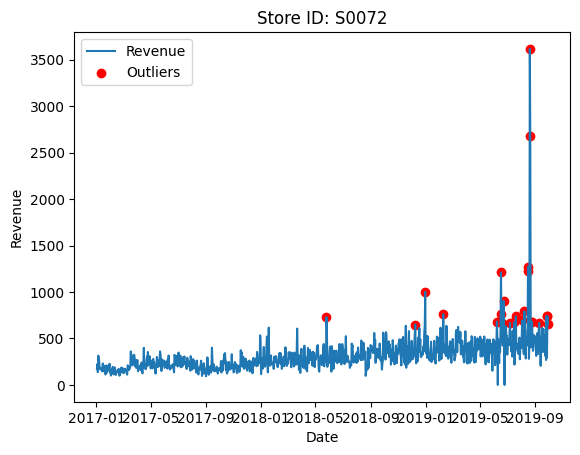

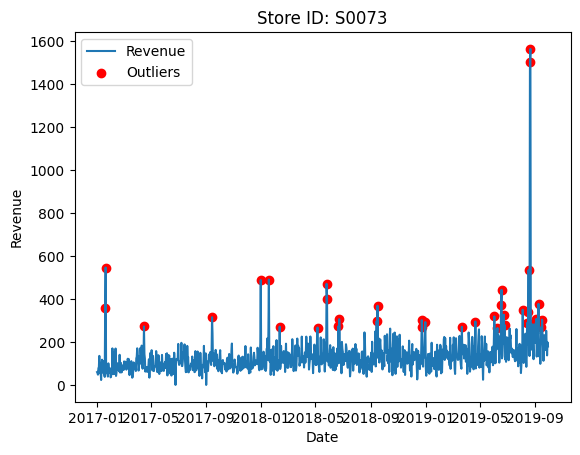

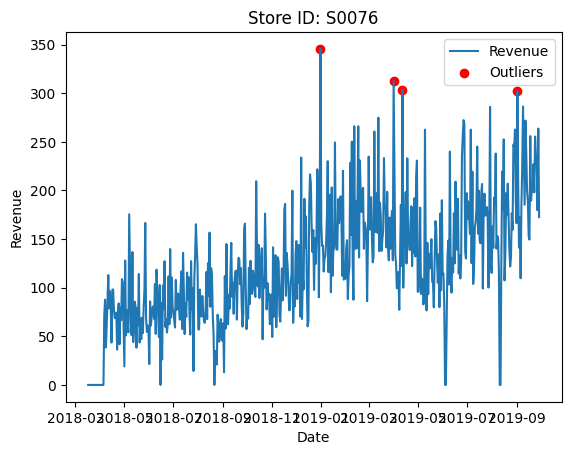

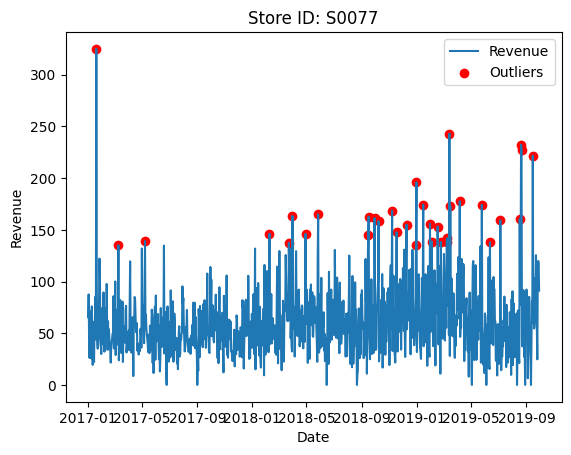

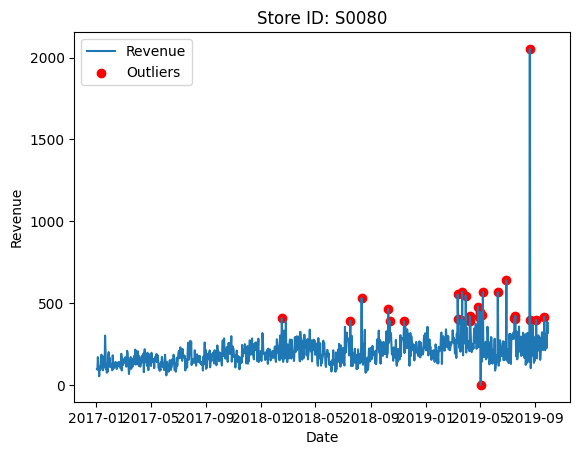

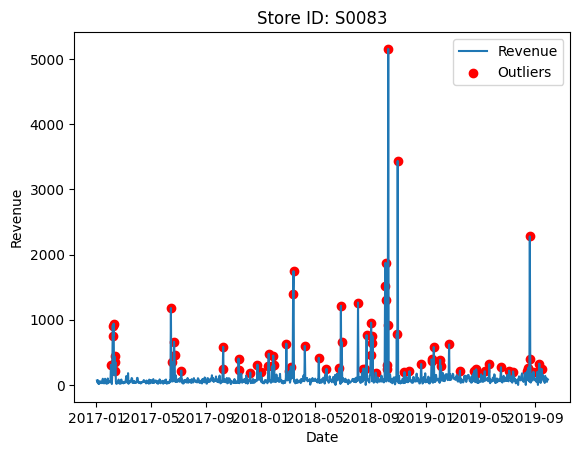

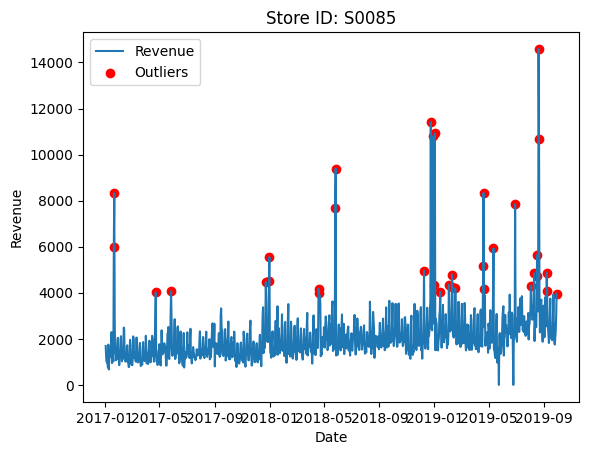

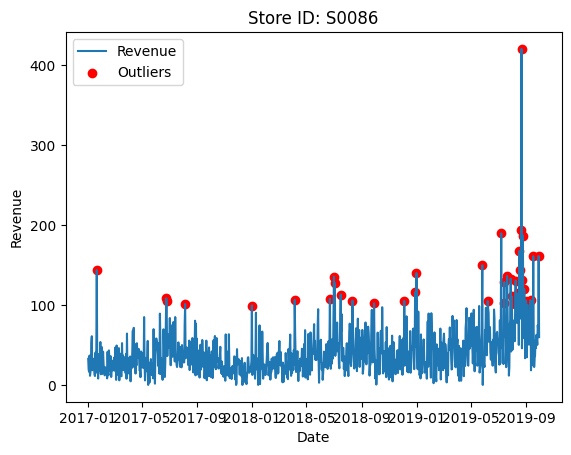

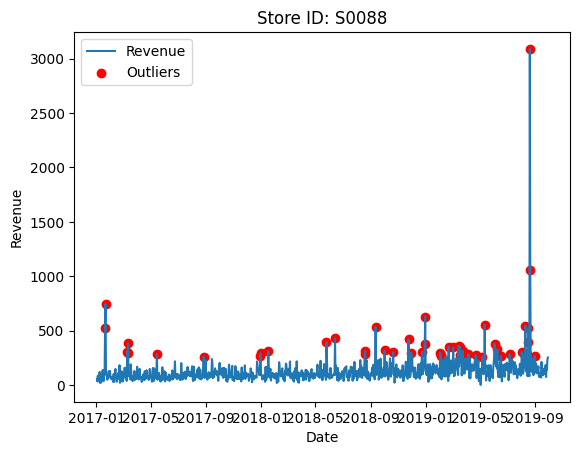

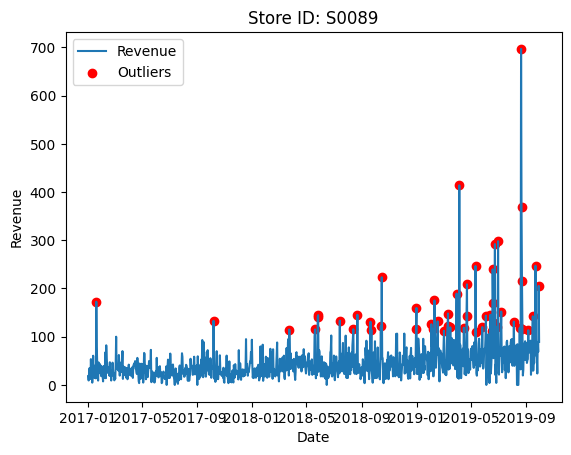

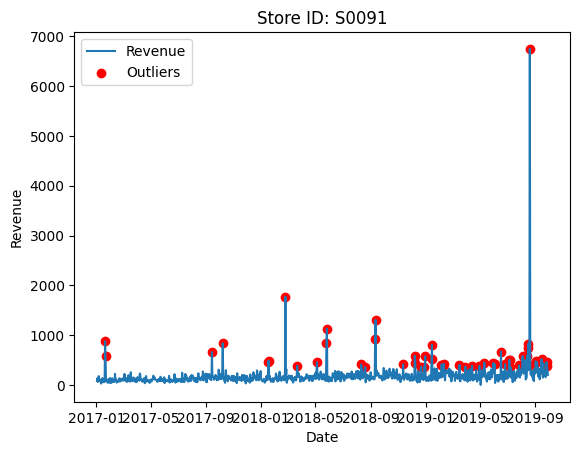

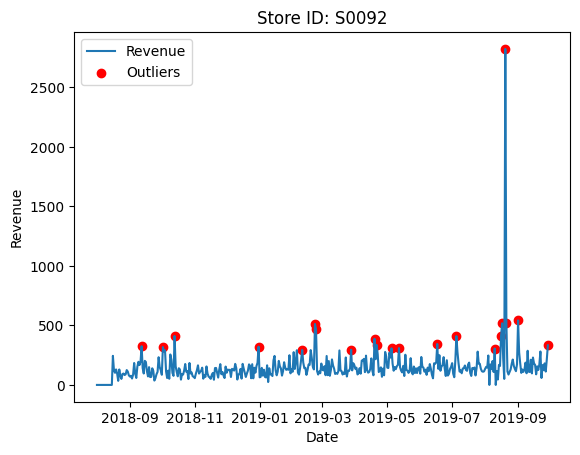

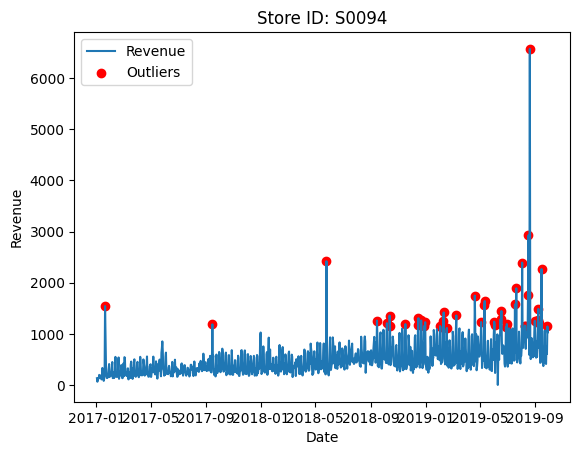

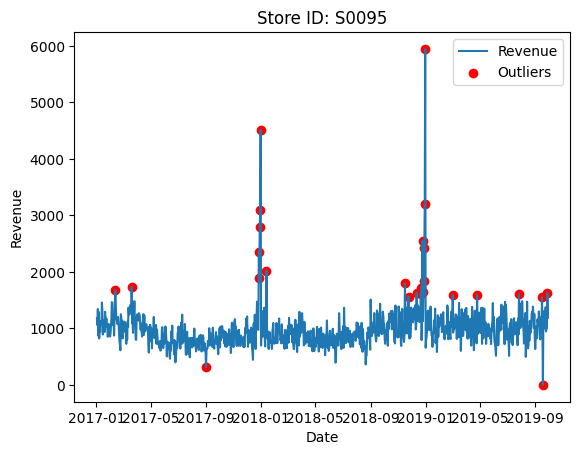

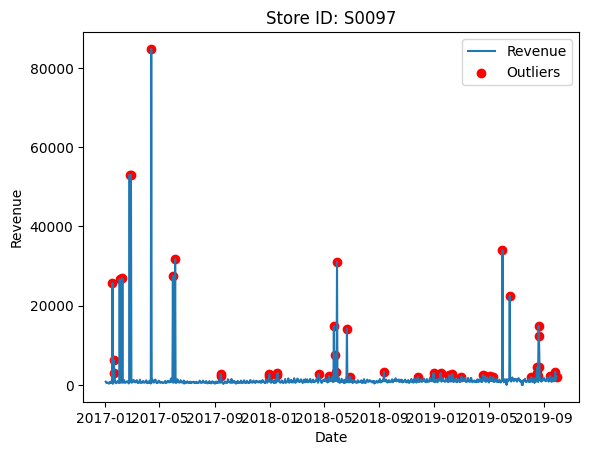

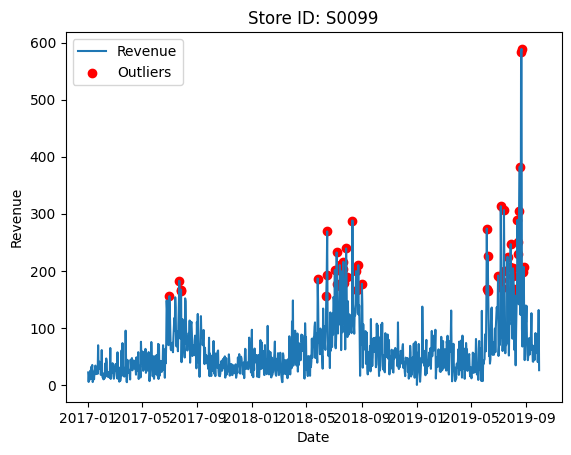

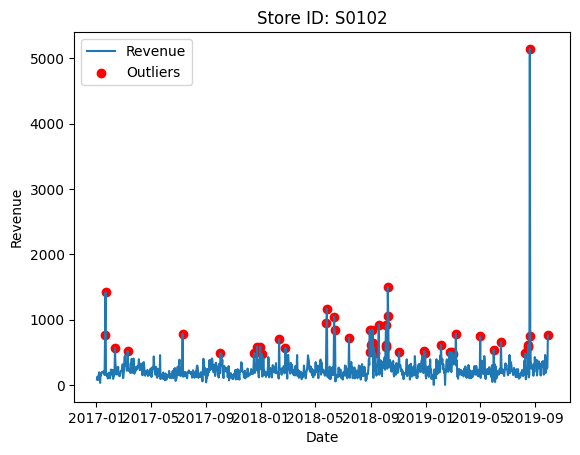

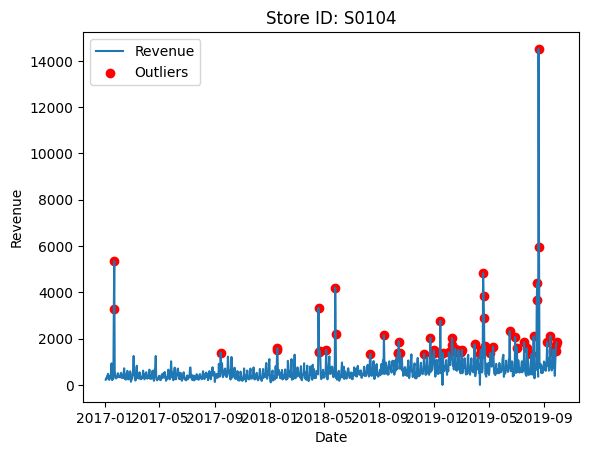

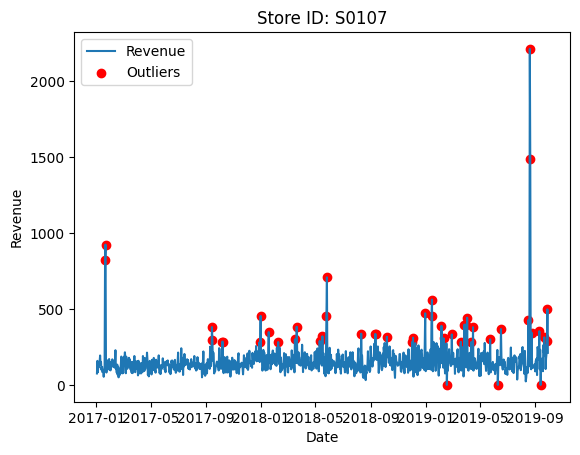

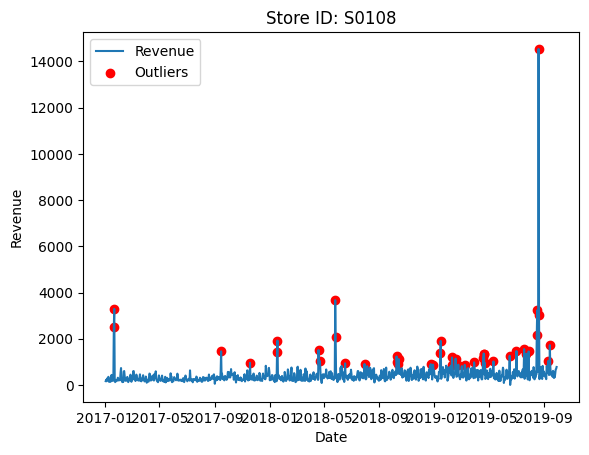

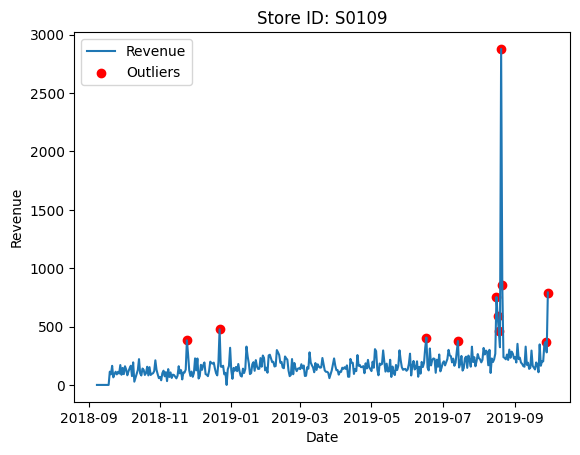

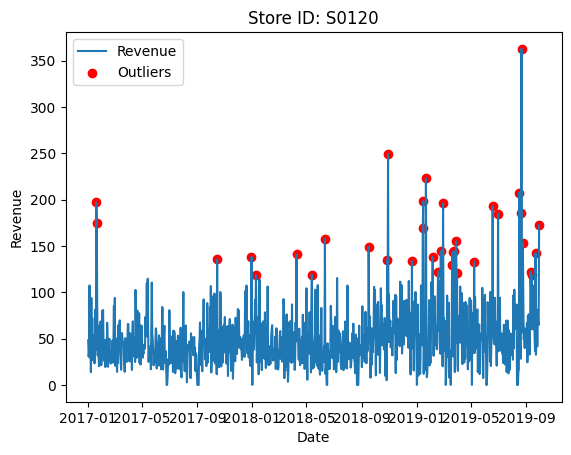

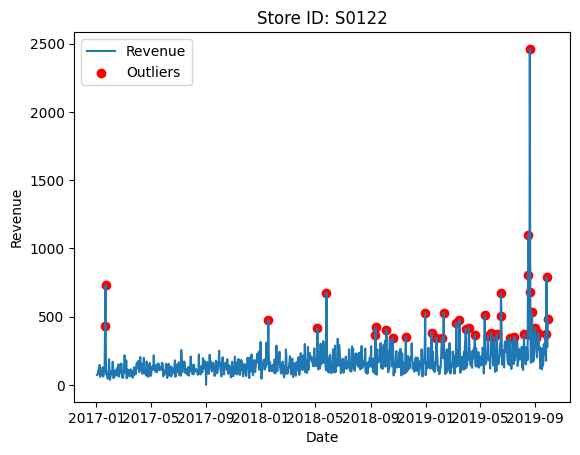

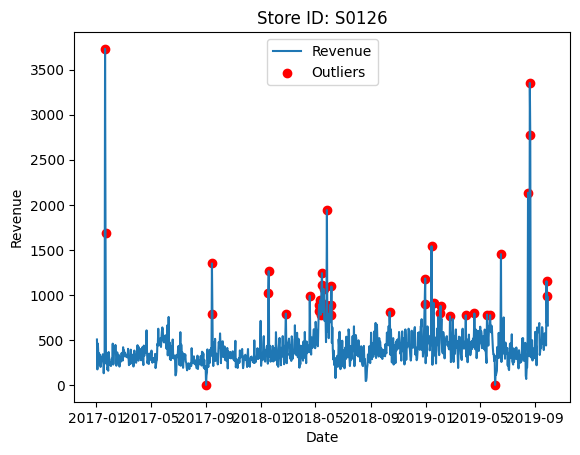

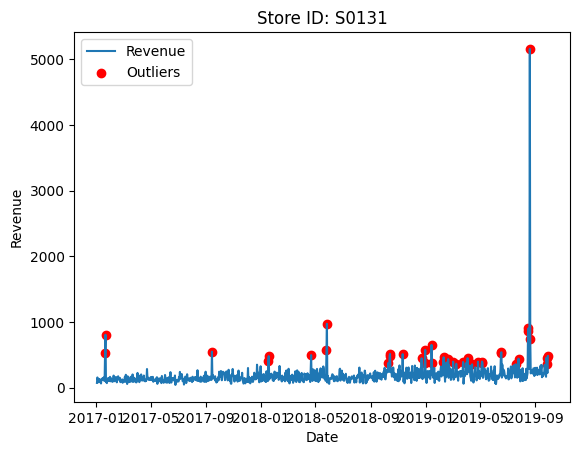

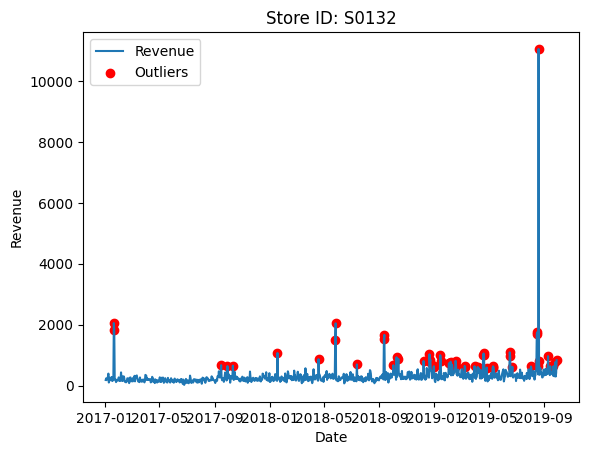

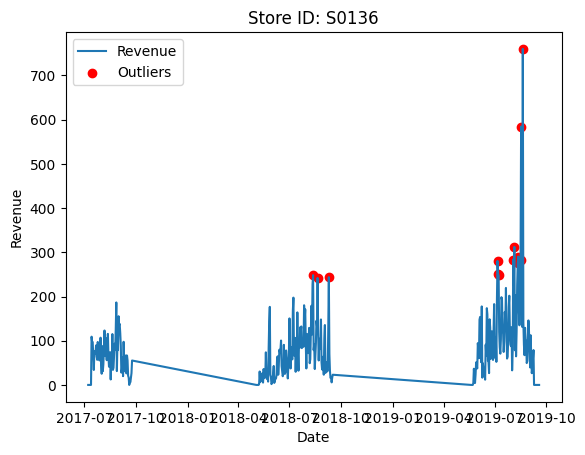

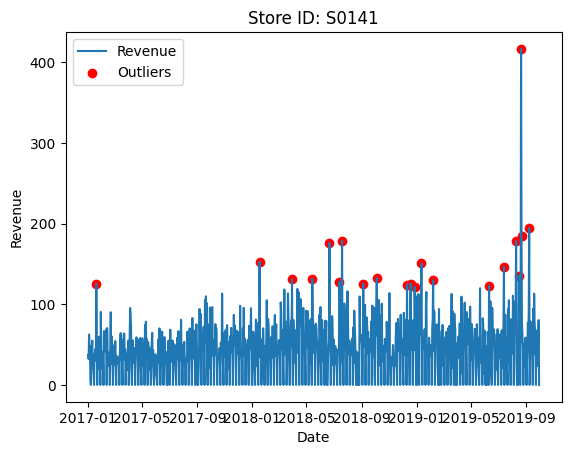

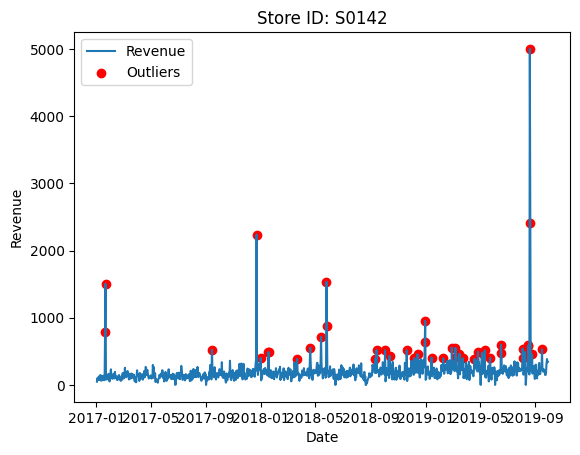

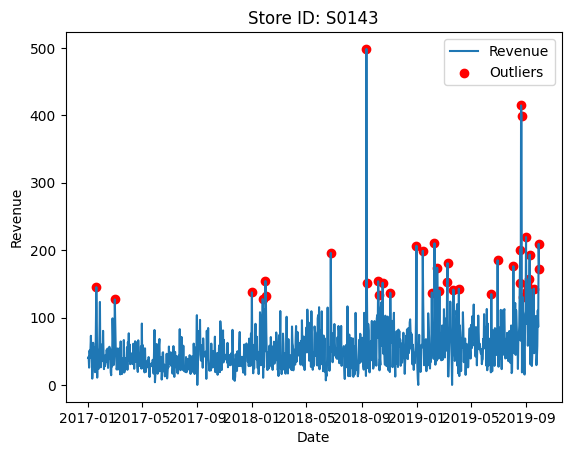

In [16]:
df = pd.read_csv('sales_df.csv')
df['date'] = pd.to_datetime(df['date'])
aggregated_df = df.groupby(['date', 'store_id']).agg({'revenue': 'sum'}).reset_index()

grouped_df = aggregated_df.groupby('store_id')
for store_id, group_data in grouped_df:
    # Calculate the IQR
    Q1 = group_data['revenue'].quantile(0.25)
    Q3 = group_data['revenue'].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = group_data[(group_data['revenue'] < lower_bound) | (group_data['revenue'] > upper_bound)]

    # Plot the data with outliers highlighted
    plt.figure()
    plt.plot(group_data['date'], group_data['revenue'], label='Revenue')
    plt.scatter(outliers['date'], outliers['revenue'], color='red', label='Outliers')
    plt.title(f"Store ID: {store_id}")
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.show()

# TESTING AREA

## Auto Arima weekly (number of sales)

### Verify the state of the data

In here we want to verify if our data is good, we have replaced null values and cleaned the data before, but in this section we want to check if there is the correct number of weeks in each year if we are missing some years among other things

In [18]:
df = pd.read_csv("sales_df.csv")
print(df)
df['date'] = pd.to_datetime(df['date'])
grouped_df = df.groupby([pd.Grouper(key='date', freq="W-SUN"), 'store_id']).agg({'revenue': 'sum'}).reset_index()
print(grouped_df)
# Count the number of weeks in each year for each store
week_counts = grouped_df.groupby(['store_id', grouped_df['date'].dt.year]).size().reset_index(name='week_count')
print(week_counts)
week_counts.to_csv("week_counts.csv", index=False)

# Add years present
year_present = grouped_df.groupby('store_id')['date'].apply(lambda x: x.dt.year.unique()).reset_index(name='year_present')
week_counts = week_counts.merge(year_present, on='store_id', how='left')

# Count the number of times a store appears
store_counts = week_counts['store_id'].value_counts().reset_index().rename(columns={'store_id': 'count'})
print(store_counts)

week_counts.to_csv("week_counts.csv", index=False)
store_counts.to_csv("store_counts.csv", index=False)

filtered_week_counts = week_counts[(week_counts['week_count'] < 52) & (week_counts['date'] < 2019)]
print(filtered_week_counts)
filtered_store_counts = store_counts[(store_counts['count'] < 3)]
print(filtered_store_counts)

last_dates = grouped_df.groupby('store_id')['date'].max().reset_index(name='last_date')
last_dates.to_csv("last_dates.csv")
print(last_dates)

# We notice that there is missing data in a lot of stores, some dont have all weeks of the year in some others complete years are missing

        store_id product_id        date  sales  revenue  stock  price  \
0          S0002      P0001  2017-01-02    0.0     0.00    8.0   6.25   
1          S0002      P0005  2017-01-02    0.0     0.00   11.0  33.90   
2          S0002      P0011  2017-01-02    0.0     0.00    9.0  49.90   
3          S0002      P0015  2017-01-02    1.0     2.41   19.0   2.60   
4          S0002      P0017  2017-01-02    0.0     0.00   12.0   1.49   
...          ...        ...         ...    ...      ...    ...    ...   
8574071    S0143      P0694  2019-09-29    0.0     0.00    7.0   7.50   
8574072    S0143      P0709  2019-09-29    0.0     0.00    7.0   7.00   
8574073    S0143      P0711  2019-09-29    0.0     0.00    5.0  12.90   
8574074    S0143      P0718  2019-09-29    0.0     0.00   14.0  23.75   
8574075    S0143      P0747  2019-09-29    0.0     0.00    3.0  21.90   

        promo_type_1 promo_bin_1  
0               PR14        none  
1               PR14        none  
2               PR

### Conclusions of this small analisys
The following stores only have information of 2 years and  the amount of data in each year  
To these stores we need to check if they only opened in 2018 and if so check that all the weeks are present  
S0005 [2018 2019] 48 39  
S0036 [2018 2019] 46 39  
S0046 [2018 2019] 43 39  
S0061 [2018 2019] 40 39  
S0071 [2018 2019] 29 39  
S0076 [2018 2019] 42 39  
S0092 [2018 2019] 22 39  
S0109 [2018 2019] 17 39  
  
The following store only has information of 1 year  
S0007 [2019] 27  

In addition to the ones before here we are displaying other stores that are missing some weeks of information eventhough there is information for the 3 years  
S0059  [2017 2018 2019] 31 52 39  
S0136  [2017 2018 2019] 12 20 19  
  
We also want to predict to the first week of October and the following store has the last information until 22 of September
S0136 2019-09-22  
  
However we are supposed to have 39 weeks in the year of 2019 because we are trying to predict the next 5 weeks 
  
However in the remaining cases there is a real problem of prediction because for a time series analysis if we defined the seasonality as 52 weeks we need atleat 104 observations to be given a prediction which is data that we dont have because we are missing entire years.  



In [19]:
df = pd.read_csv("sales_df.csv")
stores_to_delete = ["S0005", "S0036", "S0046", "S0061", "S0071", "S0076", "S0092", "S0109", "S0007", "S0059", "S0136"]
df_1 = df[~df['store_id'].isin(stores_to_delete)]
df_2 = df[~df['store_id'].isin(stores_to_delete)]
df_1['date'] = pd.to_datetime(df_1['date'])
df_2['date'] = pd.to_datetime(df_2['date'])

## Auto Arima Weekly (revenue)

In [35]:
# Step 1: Group the data by store and week
grouped_df = df_1.groupby([pd.Grouper(key='date', freq='W-SUN'), 'store_id']).agg({'revenue': 'sum'}).reset_index()
grouped_df['date'] = pd.to_datetime(grouped_df['date'])
grouped_df['year'] = grouped_df.date.dt.year
grouped_df['month'] = grouped_df.date.dt.month
grouped_df['weekofyear'] = grouped_df['date'].dt.isocalendar().week
grouped_df['is_open'] = 0
# Set 'is_open' to 1 for days where sales data is not 0
grouped_df.loc[grouped_df['revenue'] != 0, 'is_open'] = 1

# Step 2 Read other file to add information
season_holidays = pd.read_csv("season_holidays.csv")
season_holidays = season_holidays.rename(columns={'Date': 'date'})
season_holidays['date'] = pd.to_datetime(season_holidays['date'])

# Group by week and create binary columns
season_holidays = season_holidays.groupby(by=pd.Grouper(key='date', freq='W-SUN')).agg({
    'season': lambda x: ','.join(set(x)),
    'Holiday': 'any'
}).reset_index()

# Create binary columns for seasons
season_holidays['IsWinter'] = season_holidays['season'].str.contains('winter').astype(int)
season_holidays['IsSummer'] = season_holidays['season'].str.contains('summer').astype(int)
season_holidays['IsSpring'] = season_holidays['season'].str.contains('spring').astype(int)
season_holidays['IsAutumn'] = season_holidays['season'].str.contains('autumn').astype(int)

# Create binary columns for holidays
season_holidays['IsHoliday'] = season_holidays['Holiday'].astype(int)

# Shift the holiday column by 1 week to get last week's holiday
season_holidays['LastWeekHoliday'] = season_holidays['Holiday'].shift(1).fillna(False).astype(int)

# Shift the holiday column by -1 week to get next week's holiday
season_holidays['NextWeekHoliday'] = season_holidays['Holiday'].shift(-1).fillna(False).astype(int)
season_holidays.drop(['season', 'Holiday'], axis=1, inplace=True)

grouped_df = grouped_df.merge(season_holidays, on='date', how='left')
grouped_df[['revenue']] = grouped_df[['revenue']].round(2)

print(grouped_df)
grouped_df.to_csv("data_to_arima.csv", index=False)

# Step 3: Split the data into training and testing sets
test_start_week = grouped_df['date'].max() - pd.DateOffset(weeks=5)
print(test_start_week)
train_data = grouped_df[grouped_df['date'] <= test_start_week]
print(train_data)
test_data = grouped_df[grouped_df['date'] > test_start_week]
print(test_data)

           date store_id  revenue  year  month  weekofyear  is_open  IsWinter  \
0    2017-01-08    S0002  1813.24  2017      1           1        1         1   
1    2017-01-08    S0003   546.47  2017      1           1        1         1   
2    2017-01-08    S0010  2475.73  2017      1           1        1         1   
3    2017-01-08    S0012   814.01  2017      1           1        1         1   
4    2017-01-08    S0014   993.04  2017      1           1        1         1   
...         ...      ...      ...   ...    ...         ...      ...       ...   
7431 2019-09-29    S0131  2127.71  2019      9          39        1         0   
7432 2019-09-29    S0132  3429.30  2019      9          39        1         0   
7433 2019-09-29    S0141   339.91  2019      9          39        1         0   
7434 2019-09-29    S0142  1866.41  2019      9          39        1         0   
7435 2019-09-29    S0143   704.87  2019      9          39        1         0   

      IsSummer  IsSpring  I

In [37]:
# Step 4: Perform autoarima on each store's time series
predictions_arima = pd.DataFrame()
predictions_sarima = pd.DataFrame()
predictions_sarimax = pd.DataFrame()
models_arima = {}
models_sarima = {}
models_sarimax = {}
exogenous_vars = ['year', 'month', 'weekofyear', 'is_open', 'IsWinter', 'IsSummer', 
                      'IsSpring', 'IsAutumn', 'IsHoliday', 'LastWeekHoliday', 'NextWeekHoliday']
scores_df = pd.DataFrame(columns=['store', 'mae_arima', 'rmse_arima', 'mape_arima', 'mae_sarima', 'rmse_sarima', 
                                  'mape_sarima', 'mae_sarimax', 'rmse_sarimax', 'mape_sarimax'])
for store, store_data in train_data.groupby('store_id'):
    # Models arima, sarima and sarimax
    model_arima = auto_arima(store_data['revenue'], m=52, seasonal=False)
    model_sarima = auto_arima(store_data['revenue'], m=52, seasonal=True)
    model_sarimax = auto_arima(store_data['revenue'], exogenous=store_data[exogenous_vars], m=52, seasonal=True)

    # Save the best models
    models_arima[store] = model_arima
    models_sarima[store] = model_sarima
    models_sarimax[store] = model_sarimax

    # Fit the models
    model_arima.fit(store_data['revenue'])
    model_sarima.fit(store_data['revenue'])
    model_sarimax.fit(store_data['revenue'])

    # Define forecast time
    forecast_start_week = train_data[train_data['store_id'] == store]['date'].max() + pd.DateOffset(weeks=1)
    future_weeks = len(test_data[test_data['store_id'] == store])

    # Predict
    future_forecast_arima = model_arima.predict(n_periods=future_weeks, start=forecast_start_week)
    future_forecast_sarima = model_sarima.predict(n_periods=future_weeks, start=forecast_start_week)
    exogenous_data = test_data.loc[test_data['store_id'] == store, exogenous_vars]
    future_forecast_sarimax = model_sarimax.predict(n_periods=future_weeks, start=forecast_start_week, exogenous=exogenous_data)

    # Save the predictions
    predictions_arima = predictions_arima.append(pd.DataFrame(future_forecast_arima, columns=[store]).set_index(test_data[test_data['store_id'] == store].index))
    predictions_sarima = predictions_sarima.append(pd.DataFrame(future_forecast_sarima, columns=[store]).set_index(test_data[test_data['store_id'] == store].index))
    predictions_sarimax = predictions_sarimax.append(pd.DataFrame(future_forecast_sarimax, columns=[store]).set_index(test_data[test_data['store_id'] == store].index))

    # Step 5: Evaluate the models performances
    actual_revenue = test_data.loc[test_data['store_id'] == store, 'revenue']
    predicted_revenue_arima = predictions_arima.loc[test_data['store_id'] == store, store]
    predicted_revenue_sarima = predictions_sarima.loc[test_data['store_id'] == store, store]
    predicted_revenue_sarimax = predictions_sarimax.loc[test_data['store_id'] == store, store]

    mae_arima = mean_absolute_error(actual_revenue, predicted_revenue_arima)
    rmse_arima = mean_squared_error(actual_revenue, predicted_revenue_arima, squared=False)
    mape_arima = (abs((actual_revenue - predicted_revenue_arima) / actual_revenue)).mean() * 100

    mae_sarima = mean_absolute_error(actual_revenue, predicted_revenue_sarima)
    rmse_sarima = mean_squared_error(actual_revenue, predicted_revenue_sarima, squared=False)
    mape_sarima = (abs((actual_revenue - predicted_revenue_sarima) / actual_revenue)).mean() * 100

    mae_sarimax = mean_absolute_error(actual_revenue, predicted_revenue_sarimax)
    rmse_sarimax = mean_squared_error(actual_revenue, predicted_revenue_sarimax, squared=False)
    mape_sarimax = (abs((actual_revenue - predicted_revenue_sarimax) / actual_revenue)).mean() * 100

    scores_df = scores_df.append({'store': store,
                                  'mae_arima': mae_arima,
                                  'rmse_arima': rmse_arima,
                                  'mape_arima': mape_arima,
                                  'mae_sarima': mae_sarima,
                                  'rmse_sarima': rmse_sarima,
                                  'mape_sarima': mape_sarima,
                                  'mae_sarimax': mae_sarimax,
                                  'rmse_sarimax': rmse_sarimax,
                                  'mape_sarimax': mape_sarimax}, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
# Step 6: Visualize the results

# If necessary plot only the graphs with the best metrics for each store

for store in predictions_arima.columns:
    plt.figure()
    plt.plot(train_data[train_data['store_id'] == store]['revenue'], label='Train')
    plt.plot(test_data[test_data['store_id'] == store]['revenue'], label='Test')
    plt.plot(predictions_arima.loc[test_data['store_id'] == store, store], label='Predicted')
    plt.title(f"Revenue Prediction - Store {store}")
    plt.xlabel("Week")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

for store in predictions_sarima.columns:
    plt.figure()
    plt.plot(train_data[train_data['store_id'] == store]['revenue'], label='Train')
    plt.plot(test_data[test_data['store_id'] == store]['revenue'], label='Test')
    plt.plot(predictions_sarima.loc[test_data['store_id'] == store, store], label='Predicted')
    plt.title(f"Revenue Prediction - Store {store}")
    plt.xlabel("Week")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

for store in predictions_sarimax.columns:
    plt.figure()
    plt.plot(train_data[train_data['store_id'] == store]['revenue'], label='Train')
    plt.plot(test_data[test_data['store_id'] == store]['revenue'], label='Test')
    plt.plot(predictions_sarimax.loc[test_data['store_id'] == store, store], label='Predicted')
    plt.title(f"Revenue Prediction - Store {store}")
    plt.xlabel("Week")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

In [ ]:
# Define the best model for each store
"""
arima_pred = grouped_df[df['store_id']=[]]
sarima_pred = grouped_df[df['store_id']=[]] 
sarimax_pred = grouped_df[df['store_id']=[]]
"""
for store, store_data in grouped_df.groupby('store_id'):
    model_arima = models_arima[store]

    # Define forecast start and end dates
    forecast_start_week = store_data['date'].max() + pd.DateOffset(weeks=1)
    forecast_end_week = forecast_start_week + pd.DateOffset(weeks=5)

    # Predict for the next 5 weeks
    future_forecast_arima = model_arima.predict(n_periods=5, start=forecast_start_week)

    # Save the predictions for the next 5 weeks
    predictions_arima = predictions_arima.append(pd.DataFrame(future_forecast_arima, columns=[store]).set_index(pd.date_range(start=forecast_start_week, end=forecast_end_week, freq='W-SUN')))
    
# Print the predictions for the next 5 weeks
print(predictions_arima)

for store, store_data in grouped_df.groupby('store_id'):
    model_sarima = models_sarima[store]

    # Define forecast start and end dates
    forecast_start_week = store_data['date'].max() + pd.DateOffset(weeks=1)
    forecast_end_week = forecast_start_week + pd.DateOffset(weeks=5)

    # Predict for the next 5 weeks
    future_forecast_sarima = model_sarima.predict(n_periods=5, start=forecast_start_week)

    # Save the predictions for the next 5 weeks
    predictions_sarima = predictions_sarima.append(pd.DataFrame(future_forecast_sarima, columns=[store]).set_index(pd.date_range(start=forecast_start_week, end=forecast_end_week, freq='W-SUN')))

# Print the predictions for the next 5 weeks
print(predictions_sarima)

for store, store_data in grouped_df.groupby('store_id'):

    future = season_holidays.loc['date'>'2019-09-29']
    
    exogenous_data = future.loc[exogenous_vars]
    model_sarimax = models_sarimax[store]

    # Define forecast start and end dates
    forecast_start_week = store_data['date'].max() + pd.DateOffset(weeks=1)
    forecast_end_week = forecast_start_week + pd.DateOffset(weeks=5)

    # Predict for the next 5 weeks
    future_forecast_sarimax = model_sarimax.predict(n_periods=5, start=forecast_start_week, exogenous=exogenous_data)

    # Save the predictions for the next 5 weeks
    predictions_sarimax = predictions_sarimax.append(pd.DataFrame(future_forecast_sarimax, columns=[store]).set_index(pd.date_range(start=forecast_start_week, end=forecast_end_week, freq='W-SUN')))

# Print the predictions for the next 5 weeks
print(predictions_sarimax)
